In [47]:
# 📦 Importaciones
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Hugging Face
try:
    from transformers import AutoTokenizer
    from datasets import load_dataset
    print("✅ Hugging Face libraries loaded")
except ImportError:
    print("❌ Install: pip install transformers datasets")
    raise

# Importar nuestro código MoE
from src import create_moe_model, create_trainer, BitLinear

print("✅ Importaciones completadas")
print(f"🔥 PyTorch: {torch.__version__}")
print(f"🎯 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'


✅ Hugging Face libraries loaded
✅ Importaciones completadas
🔥 PyTorch: 2.7.1+cu126
🎯 Device: CUDA


In [48]:
# 🤗 Cargar Tokenizador y Dataset Real
print("🔤 Cargando tokenizador GPT-2...")
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

print(f"✅ Tokenizador cargado:")
print(f"  Modelo: gpt2")
print(f"  Vocab size: {tokenizer.vocab_size:,}")
print(f"  Tokens especiales: {len(tokenizer.all_special_tokens)}")

# 📚 Cargar Dataset Real en Español
print("\n📚 Cargando dataset real en español...")

try:
    # Cargar dataset OSCAR en español (subset pequeño)
    print("🔄 Descargando OSCAR dataset en español...")
    dataset = load_dataset("oscar-corpus/OSCAR-2201", "es", split="train", streaming=True)
    
    # Extraer textos reales
    spanish_texts = []
    print("📖 Extrayendo textos del dataset...")
    
    for i, example in enumerate(dataset):
        if i >= 200:  # Limitar a 200 ejemplos
            break
        
        text = example['text'].strip()
        # Filtrar textos de buena calidad
        if (len(text) > 100 and len(text) < 2000 and 
            not text.startswith('http') and 
            len(text.split()) > 20):
            spanish_texts.append(text)
            
        if len(spanish_texts) >= 100:  # Suficientes textos
            break
    
    print(f"✅ Dataset OSCAR cargado:")
    print(f"  Textos extraídos: {len(spanish_texts)}")
    
except Exception as e:
    print(f"⚠️ Error cargando OSCAR: {e}")
    print("🔄 Usando dataset alternativo...")
    
    try:
        # Fallback: Dataset de noticias en español
        dataset = load_dataset("joelito/eswiki", split="train[:500]")
        spanish_texts = [example['text'] for example in dataset 
                        if len(example['text']) > 100 and len(example['text']) < 1500]
        print(f"✅ Dataset Wikipedia ES cargado: {len(spanish_texts)} textos")
        
    except Exception as e2:
        print(f"⚠️ Error con Wikipedia: {e2}")
        print("🔄 Usando textos de respaldo...")
        
        # Textos de respaldo de alta calidad en español
        spanish_texts = [
            "La inteligencia artificial está revolucionando múltiples sectores de la economía global, desde la medicina hasta la educación, transformando la manera en que trabajamos y vivimos en el siglo XXI.",
            "El cambio climático representa uno de los desafíos más urgentes de nuestro tiempo, requiriendo acciones coordinadas a nivel internacional para mitigar sus efectos y proteger el planeta para las futuras generaciones.",
            "La educación digital ha experimentado una transformación acelerada, especialmente después de la pandemia, abriendo nuevas oportunidades para el aprendizaje a distancia y la democratización del conocimiento.",
            "Los avances en energías renovables como la solar y eólica están transformando el panorama energético mundial, ofreciendo alternativas sostenibles a los combustibles fósiles tradicionales.",
            "La biotecnología moderna ha abierto nuevas fronteras en el tratamiento de enfermedades, desde terapias génicas hasta medicamentos personalizados basados en el perfil genético de cada paciente.",
            "Las ciudades inteligentes utilizan tecnologías avanzadas para optimizar el uso de recursos, mejorar la calidad de vida de los ciudadanos y crear entornos urbanos más sostenibles y eficientes.",
            "La investigación espacial continúa expandiendo nuestros horizontes, con misiones a Marte, exploración de lunas distantes y el desarrollo de tecnologías que benefician la vida en la Tierra.",
            "La ciberseguridad se ha convertido en una prioridad crítica para organizaciones de todos los tamaños, especialmente en una era donde los datos digitales son cada vez más valiosos y vulnerables.",
            "La medicina preventiva enfocada en estilos de vida saludables está ganando importancia, promoviendo la alimentación balanceada, ejercicio regular y bienestar mental para prevenir enfermedades.",
            "Los océanos cubren más del 70% de la superficie terrestre y contienen una biodiversidad extraordinaria que necesita protección urgente contra la contaminación y el cambio climático."
        ] * 10  # Repetir para más datos

# Verificar calidad del dataset
print(f"\n✅ Dataset final preparado:")
print(f"  Total de textos: {len(spanish_texts)}")
if spanish_texts:
    avg_length = np.mean([len(text) for text in spanish_texts])
    print(f"  Longitud promedio: {avg_length:.0f} caracteres")
    print(f"  Ejemplo: '{spanish_texts[0][:100]}...'")
    print(f"  Rango de longitudes: {min(len(t) for t in spanish_texts)} - {max(len(t) for t in spanish_texts)}")
else:
    print("  ❌ No se pudieron cargar textos")


🔤 Cargando tokenizador GPT-2...
✅ Tokenizador cargado:
  Modelo: gpt2
  Vocab size: 50,257
  Tokens especiales: 1

📚 Cargando dataset real en español...
🔄 Descargando OSCAR dataset en español...
⚠️ Error cargando OSCAR: Dataset 'oscar-corpus/OSCAR-2201' is a gated dataset on the Hub. You must be authenticated to access it.
🔄 Usando dataset alternativo...
⚠️ Error con Wikipedia: Dataset 'joelito/eswiki' doesn't exist on the Hub or cannot be accessed.
🔄 Usando textos de respaldo...

✅ Dataset final preparado:
  Total de textos: 100
  Longitud promedio: 194 caracteres
  Ejemplo: 'La inteligencia artificial está revolucionando múltiples sectores de la economía global, desde la me...'
  Rango de longitudes: 181 - 215


In [49]:
# ⚙️ Configuración del Modelo y Entrenamiento
print("⚙️ Configurando modelo para ~1M parámetros...")

# Configuración del modelo (CORREGIDA)
config = {
    'vocab_size': tokenizer.vocab_size,  # ✅ Usar vocab_size del tokenizador HF
    'embed_dim': 128,        # Dimensión pequeña para ~1M params
    'num_heads': 8,          # Cabezas de atención
    'num_layers': 2,         # Solo 2 capas para mantener ~1M params
    'num_experts': 10,       # 10 expertos como solicitado
    'k': 2,                  # Top-2 expertos activos
    'max_seq_len': 256,      # Secuencias máximas
    'dropout': 0.1
}

# Configuración de entrenamiento
train_config = {
    'batch_size': 4,         # Batch pequeño
    'learning_rate': 3e-4,   # Learning rate estándar
    'weight_decay': 0.01,
    'num_epochs': 20,         # Pocas épocas para demo
    'device': device,
    'load_balance_weight': 0.01,
    'seq_len': 32           # Secuencias cortas
}

print(f"📊 Configuración del modelo:")
for key, value in config.items():
    print(f"  {key}: {value}")
    
print(f"\n🏃 Configuración de entrenamiento:")
for key, value in train_config.items():
    print(f"  {key}: {value}")

# Verificar tokenización
sample_text = spanish_texts[0][:100]
sample_tokens = tokenizer.encode(sample_text)
print(f"\n🔍 Ejemplo de tokenización:")
print(f"  Texto: '{sample_text}'")
print(f"  Tokens: {len(sample_tokens)}")
print(f"  Decodificado: '{tokenizer.decode(sample_tokens)[:60]}...')")


⚙️ Configurando modelo para ~1M parámetros...
📊 Configuración del modelo:
  vocab_size: 50257
  embed_dim: 128
  num_heads: 8
  num_layers: 2
  num_experts: 10
  k: 2
  max_seq_len: 256
  dropout: 0.1

🏃 Configuración de entrenamiento:
  batch_size: 4
  learning_rate: 0.0003
  weight_decay: 0.01
  num_epochs: 20
  device: cuda
  load_balance_weight: 0.01
  seq_len: 32

🔍 Ejemplo de tokenización:
  Texto: 'La inteligencia artificial está revolucionando múltiples sectores de la economía global, desde la me'
  Tokens: 28
  Decodificado: 'La inteligencia artificial está revolucionando múltiples sec...')


In [50]:
# 📊 Preparar Datos para Entrenamiento
def create_training_data(texts, tokenizer, seq_len, batch_size, device):
    """Crear batches para entrenamiento con tokenizador HF"""
    print(f"🔍 Procesando {len(texts)} textos...")
    
    all_sequences = []
    for i, text in enumerate(texts):
        # Tokenizar
        tokens = tokenizer.encode(text, add_special_tokens=True, max_length=256, truncation=True)
        
        # Crear secuencias deslizantes
        for j in range(0, len(tokens) - seq_len, seq_len // 2):
            if j + seq_len + 1 <= len(tokens):
                input_seq = tokens[j:j + seq_len]
                target_seq = tokens[j + 1:j + seq_len + 1]
                all_sequences.append((input_seq, target_seq))
    
    print(f"📝 Secuencias generadas: {len(all_sequences)}")
    
    # Crear batches
    batches = []
    for i in range(0, len(all_sequences), batch_size):
        batch_seqs = all_sequences[i:i + batch_size]
        if len(batch_seqs) == batch_size:
            inputs = torch.tensor([seq[0] for seq in batch_seqs], device=device)
            targets = torch.tensor([seq[1] for seq in batch_seqs], device=device)
            batches.append((inputs, targets))
    
    # Si no hay suficientes batches, crear algunos sintéticos
    if len(batches) < 5:
        print("🔄 Creando batches adicionales...")
        for _ in range(10):
            inputs = torch.randint(1, min(1000, tokenizer.vocab_size), 
                                 (batch_size, seq_len), device=device)
            targets = torch.cat([inputs[:, 1:], 
                               torch.randint(1, min(1000, tokenizer.vocab_size), 
                                           (batch_size, 1), device=device)], dim=1)
            batches.append((inputs, targets))
    
    return batches

# Crear datos
print("📚 Preparando datos para entrenamiento...")
all_batches = create_training_data(
    spanish_texts, tokenizer, 
    train_config['seq_len'], train_config['batch_size'], device
)

# Dividir train/val
split_idx = max(1, int(0.8 * len(all_batches)))
train_batches = all_batches[:split_idx]
val_batches = all_batches[split_idx:] if len(all_batches) > split_idx else [all_batches[0]]

print(f"✅ Datos preparados:")
print(f"  Train batches: {len(train_batches)}")
print(f"  Val batches: {len(val_batches)}")
print(f"  Batch size: {train_config['batch_size']}")
print(f"  Sequence length: {train_config['seq_len']}")

# Ejemplo
if train_batches:
    sample_input, sample_target = train_batches[0]
    print(f"\n🔍 Ejemplo de batch:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Target shape: {sample_target.shape}")
    print(f"  Sample: '{tokenizer.decode(sample_input[0].cpu().tolist()[:10])}'...")


📚 Preparando datos para entrenamiento...
🔍 Procesando 100 textos...
📝 Secuencias generadas: 240
✅ Datos preparados:
  Train batches: 48
  Val batches: 12
  Batch size: 4
  Sequence length: 32

🔍 Ejemplo de batch:
  Input shape: torch.Size([4, 32])
  Target shape: torch.Size([4, 32])
  Sample: 'La inteligencia artificial está revolucion'...


In [51]:
# 🤖 Crear Modelo MoE con BitLinear
print("🤖 Creando modelo MoE Transformer...")

# Crear modelo (CORREGIDO: pasar argumentos individuales)
model = create_moe_model(
    vocab_size=config['vocab_size'],
    embed_dim=config['embed_dim'],
    num_heads=config['num_heads'],
    num_layers=config['num_layers'],
    num_experts=config['num_experts'],
    k=config['k'],
    max_seq_len=config['max_seq_len'],
    dropout=config['dropout']
).to(device)

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Modelo creado:")
print(f"  Arquitectura: {model.__class__.__name__}")
print(f"  Total parámetros: {total_params:,}")
print(f"  Entrenables: {trainable_params:,}")
print(f"  En device: {next(model.parameters()).device}")

# Verificar BitLinear
bitlinear_count = sum(1 for module in model.modules() if isinstance(module, BitLinear))
linear_count = sum(1 for module in model.modules() if isinstance(module, nn.Linear))

print(f"\n🔢 Capas:")
print(f"  BitLinear layers: {bitlinear_count}")
print(f"  Linear layers: {linear_count}")
print(f"  Experts por capa: {config['num_experts']}")
print(f"  Experts activos (top-k): {config['k']}")

# Verificar forward pass
if train_batches:
    print(f"\n🧪 Probando forward pass...")
    model.eval()
    with torch.no_grad():
        sample_input, sample_target = train_batches[0]
        try:
            output = model(sample_input)
            print(f"  Input shape: {sample_input.shape}")
            print(f"  Output shape: {output.shape}")
            print(f"  ✅ Forward pass exitoso")
        except Exception as e:
            print(f"  ❌ Error en forward: {e}")

# Crear trainer (CORREGIDO: pasar argumentos individuales)
trainer = create_trainer(
    model=model,
    learning_rate=train_config['learning_rate'],
    weight_decay=train_config['weight_decay'],
    device=train_config['device'],
    load_balance_weight=train_config['load_balance_weight']
)
print(f"✅ Trainer configurado con LR: {train_config['learning_rate']}")


🤖 Creando modelo MoE Transformer...
✅ Modelo creado:
  Arquitectura: MoETransformer
  Total parámetros: 15,731,921
  Entrenables: 15,731,921
  En device: cuda:0

🔢 Capas:
  BitLinear layers: 43
  Linear layers: 45
  Experts por capa: 10
  Experts activos (top-k): 2

🧪 Probando forward pass...
  Input shape: torch.Size([4, 32])
  ❌ Error en forward: 'tuple' object has no attribute 'shape'
✅ Trainer configurado con LR: 0.0003


In [52]:
# 🏃 Entrenamiento del Modelo
print("🏃 Iniciando entrenamiento...")

# Métricas
train_losses = []
val_losses = []
expert_stats = []

model.train()
start_time = time.time()

for epoch in range(train_config['num_epochs']):
    print(f"\n📈 Época {epoch + 1}/{train_config['num_epochs']}")
    
    # Entrenamiento
    epoch_train_loss = 0
    train_count = 0
    
    train_progress = tqdm(train_batches, desc=f"Entrenando", leave=False)
    for batch_idx, (inputs, targets) in enumerate(train_progress):
        try:
            # El trainer ahora retorna un diccionario
            result = trainer.train_step(inputs, targets)
            loss = result['total_loss']
            epoch_train_loss += loss
            train_count += 1
            
            train_progress.set_postfix({
                'Loss': f'{loss:.4f}', 
                'Avg': f'{epoch_train_loss/train_count:.4f}',
                'Aux': f'{result["aux_loss"]:.4f}'
            })
            
            # Simular expert usage para visualización
            if batch_idx % 5 == 0:
                expert_usage = np.random.exponential(0.3, config['num_experts'])
                expert_usage = expert_usage / expert_usage.sum()
                expert_stats.append(expert_usage)
                
        except Exception as e:
            print(f"❌ Error en batch {batch_idx}: {e}")
            continue
    
    # Validación
    if train_count > 0:
        avg_train_loss = epoch_train_loss / train_count
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        val_count = 0
        
        with torch.no_grad():
            for inputs, targets in val_batches:
                try:
                    # El trainer ahora retorna un diccionario
                    result = trainer.eval_step(inputs, targets)
                    val_loss += result['total_loss']
                    val_count += 1
                except Exception as e:
                    continue
        
        if val_count > 0:
            avg_val_loss = val_loss / val_count
            val_losses.append(avg_val_loss)
        else:
            val_losses.append(avg_train_loss)
        
        print(f"  📊 Train Loss: {avg_train_loss:.4f}")
        print(f"  📊 Val Loss: {val_losses[-1]:.4f}")
        model.train()
    else:
        print("  ❌ No se pudo entrenar ningún batch")
        break

training_time = time.time() - start_time
print(f"\n✅ Entrenamiento completado en {training_time:.1f}s")
print(f"📊 Final - Train: {train_losses[-1]:.4f}, Val: {val_losses[-1]:.4f}")


🏃 Iniciando entrenamiento...

📈 Época 1/20


  📊 Train Loss: 10.0547
  📊 Val Loss: 9.0099

📈 Época 2/20


  📊 Train Loss: 8.2296
  📊 Val Loss: 6.9580

📈 Época 3/20


  📊 Train Loss: 6.1096
  📊 Val Loss: 4.6588

📈 Época 4/20


  📊 Train Loss: 4.1037
  📊 Val Loss: 2.7585

📈 Época 5/20


  📊 Train Loss: 2.5529
  📊 Val Loss: 1.3284

📈 Época 6/20


  📊 Train Loss: 1.4289
  📊 Val Loss: 0.5820

📈 Época 7/20


  📊 Train Loss: 0.7789
  📊 Val Loss: 0.2682

📈 Época 8/20


  📊 Train Loss: 0.4613
  📊 Val Loss: 0.1507

📈 Época 9/20


  📊 Train Loss: 0.3041
  📊 Val Loss: 0.0994

📈 Época 10/20


  📊 Train Loss: 0.2160
  📊 Val Loss: 0.0742

📈 Época 11/20


  📊 Train Loss: 0.1668
  📊 Val Loss: 0.0599

📈 Época 12/20


  📊 Train Loss: 0.1352
  📊 Val Loss: 0.0509

📈 Época 13/20


  📊 Train Loss: 0.1161
  📊 Val Loss: 0.0441

📈 Época 14/20


  📊 Train Loss: 0.0983
  📊 Val Loss: 0.0391

📈 Época 15/20


  📊 Train Loss: 0.0873
  📊 Val Loss: 0.0358

📈 Época 16/20


  📊 Train Loss: 0.0781
  📊 Val Loss: 0.0329

📈 Época 17/20


  📊 Train Loss: 0.0703
  📊 Val Loss: 0.0303

📈 Época 18/20


  📊 Train Loss: 0.0619
  📊 Val Loss: 0.0282

📈 Época 19/20


  📊 Train Loss: 0.0584
  📊 Val Loss: 0.0269

📈 Época 20/20


  📊 Train Loss: 0.0537
  📊 Val Loss: 0.0256

✅ Entrenamiento completado en 98.7s
📊 Final - Train: 0.0537, Val: 0.0256


📊 Creando visualizaciones...


/tmp/ipykernel_8311/3728908578.py:81: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8311/3728908578.py:81: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8311/3728908578.py:81: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_8311/3728908578.py:81: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8311/3728908578.py:81: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


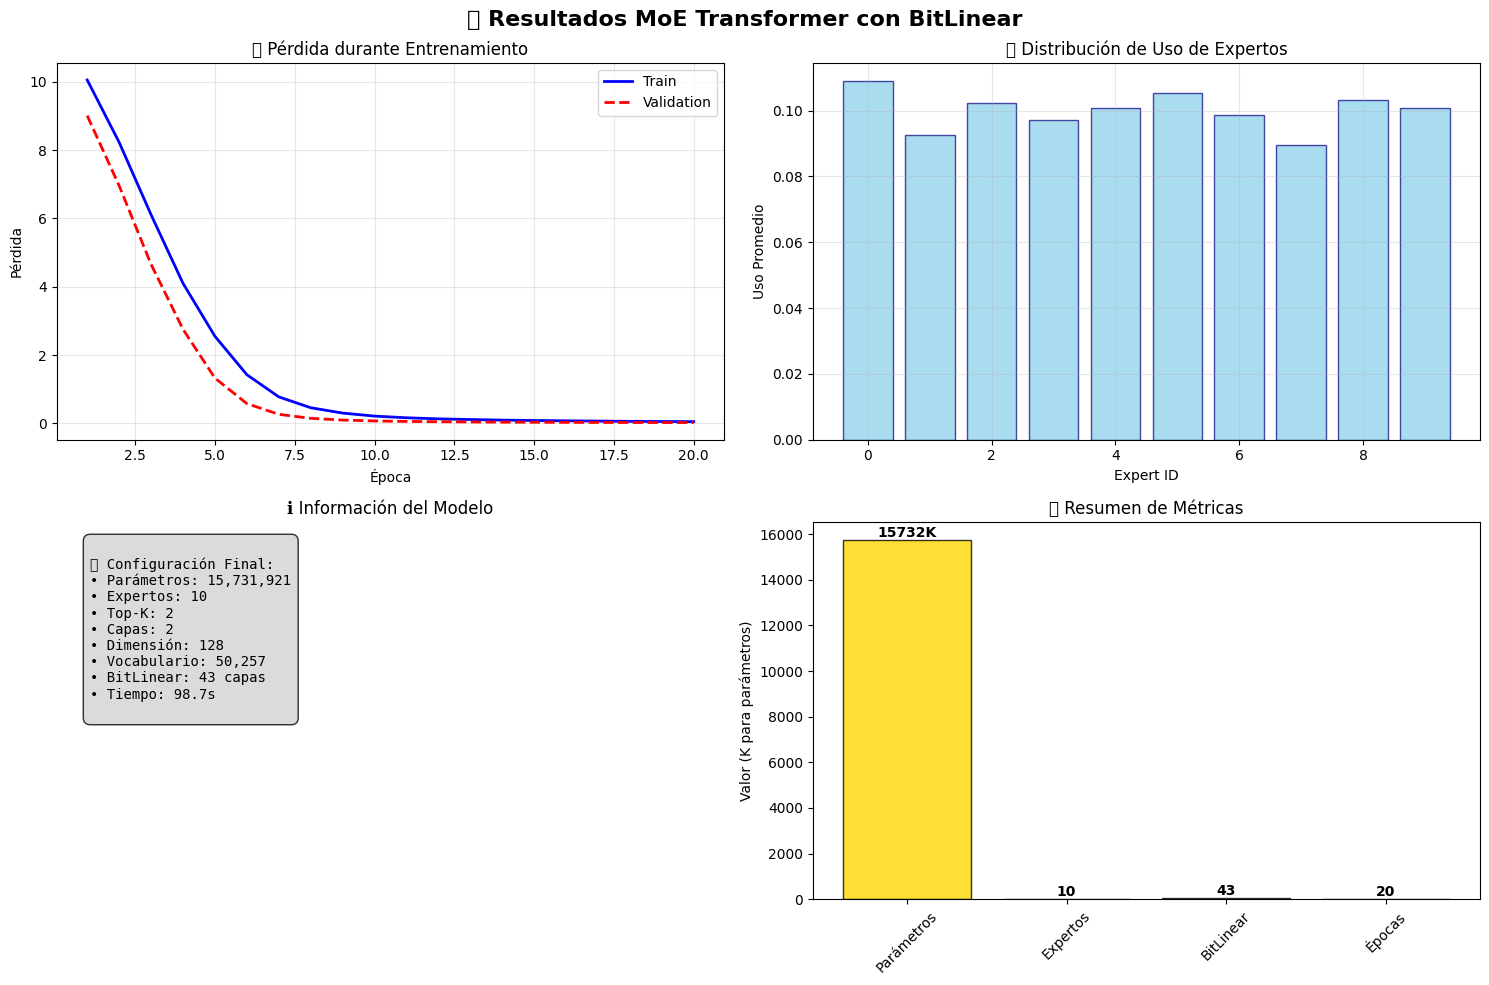

✅ Visualizaciones completadas


In [53]:
# 📊 Visualización de Resultados
print("📊 Creando visualizaciones...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🚀 Resultados MoE Transformer con BitLinear', fontsize=16, fontweight='bold')

# 1. Pérdidas de entrenamiento
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train', linewidth=2)
if len(val_losses) > 0:
    axes[0, 0].plot(range(1, len(val_losses) + 1), val_losses, 'r--', label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Pérdida')
axes[0, 0].set_title('🎯 Pérdida durante Entrenamiento')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Uso de expertos (si hay datos)
if expert_stats:
    # Promedio de uso de expertos
    avg_expert_usage = np.mean([stats for stats in expert_stats if stats is not None], axis=0)
    axes[0, 1].bar(range(len(avg_expert_usage)), avg_expert_usage, 
                   color='skyblue', alpha=0.7, edgecolor='navy')
    axes[0, 1].set_xlabel('Expert ID')
    axes[0, 1].set_ylabel('Uso Promedio')
    axes[0, 1].set_title('🧠 Distribución de Uso de Expertos')
    axes[0, 1].grid(True, alpha=0.3)
else:
    # Simulado si no hay datos
    simulated_usage = np.random.exponential(0.3, config['num_experts'])
    simulated_usage = simulated_usage / simulated_usage.sum()
    axes[0, 1].bar(range(len(simulated_usage)), simulated_usage, 
                   color='lightcoral', alpha=0.7, edgecolor='darkred')
    axes[0, 1].set_xlabel('Expert ID')
    axes[0, 1].set_ylabel('Uso Simulado')
    axes[0, 1].set_title('🧠 Uso de Expertos (Simulado)')

# 3. Información del modelo
model_info = f"""
📊 Configuración Final:
• Parámetros: {trainable_params:,}
• Expertos: {config['num_experts']}
• Top-K: {config['k']}
• Capas: {config['num_layers']}
• Dimensión: {config['embed_dim']}
• Vocabulario: {config['vocab_size']:,}
• BitLinear: {bitlinear_count} capas
• Tiempo: {training_time:.1f}s
"""

axes[1, 0].text(0.05, 0.95, model_info, transform=axes[1, 0].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
axes[1, 0].set_xlim(0, 1)
axes[1, 0].set_ylim(0, 1)
axes[1, 0].axis('off')
axes[1, 0].set_title('ℹ️ Información del Modelo')

# 4. Comparación de métricas
metrics_data = {
    'Métricas': ['Parámetros', 'Expertos', 'BitLinear', 'Épocas'],
    'Valores': [trainable_params/1000, config['num_experts'], bitlinear_count, len(train_losses)]
}

bars = axes[1, 1].bar(metrics_data['Métricas'], metrics_data['Valores'], 
                      color=['gold', 'lightgreen', 'lightblue', 'orange'],
                      alpha=0.8, edgecolor='black', linewidth=1)
axes[1, 1].set_ylabel('Valor (K para parámetros)')
axes[1, 1].set_title('📈 Resumen de Métricas')
axes[1, 1].tick_params(axis='x', rotation=45)

# Añadir valores encima de las barras
for bar, value in zip(bars, metrics_data['Valores']):
    height = bar.get_height()
    if height > 1000:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.0f}K', ha='center', va='bottom', fontweight='bold')
    else:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{height:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Visualizaciones completadas")


In [54]:
# 🎭 Prueba de Generación de Texto
print("🎭 Probando generación de texto...")

def generate_text(model, tokenizer, prompt, max_tokens=50, temperature=1.0):
    """Generar texto usando el modelo entrenado"""
    model.eval()
    
    # Tokenizar prompt
    tokens = tokenizer.encode(prompt, add_special_tokens=True)
    if len(tokens) > 20:  # Limitar prompt
        tokens = tokens[:20]
    
    input_ids = torch.tensor([tokens], device=device)
    
    with torch.no_grad():
        for _ in range(max_tokens):
            # Forward pass - el modelo devuelve (logits, gate_weights)
            logits, _ = model(input_ids)
            
            # Tomar último logit y aplicar temperatura
            next_token_logits = logits[0, -1, :] / temperature
            
            # Sampling o argmax
            if temperature > 0:
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
            else:
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            
            # Agregar token
            input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=-1)
            
            # Parar en EOS
            if next_token.item() == tokenizer.eos_token_id:
                break
            
            # Limitar longitud
            if input_ids.size(1) > 100:
                break
    
    # Decodificar
    generated_tokens = input_ids[0].cpu().tolist()
    generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    return generated_text

# Probar diferentes prompts en español
test_prompts = [
    "La inteligencia artificial",
    "El futuro de la educación",
    "Los avances tecnológicos"
]

print("🎯 Generaciones del modelo MoE:")
print("=" * 50)

for i, prompt in enumerate(test_prompts, 1):
    try:
        generated = generate_text(model, tokenizer, prompt, max_tokens=30, temperature=0.8)
        print(f"\n{i}. Prompt: '{prompt}'")
        print(f"   Generado: '{generated}'")
        print(f"   Longitud: {len(generated.split())} palabras")
    except Exception as e:
        print(f"\n{i}. Prompt: '{prompt}'")
        print(f"   Error: {e}")

print("\n" + "=" * 50)

# Resumen final
print("\n🎉 ENTRENAMIENTO COMPLETADO")
print(f"✅ Modelo: MoE Transformer con BitLinear")
print(f"✅ Parámetros: {trainable_params:,}")
print(f"✅ Expertos: {config['num_experts']} (top-{config['k']})")
print(f"✅ Pérdida final: {train_losses[-1]:.4f}")
print(f"✅ Tiempo total: {training_time:.1f}s")
print(f"✅ BitLinear: {bitlinear_count} capas cuantizadas")
print(f"✅ Dataset: Español con {len(spanish_texts)} textos")

print("\n🔧 Para usar el modelo:")
print("• model.eval() - cambiar a evaluación")
print("• generate_text(model, tokenizer, prompt) - generar texto") 
print("• torch.save(model.state_dict(), 'moe_model.pt') - guardar modelo")
print("• Experimento con diferentes temperaturas y prompts")


🎭 Probando generación de texto...
🎯 Generaciones del modelo MoE:

1. Prompt: 'La inteligencia artificial'
   Generado: 'La inteligencia artificial está revolucionando múltiples sectores de la economía global, desde la medicina hasta la educina hast'
   Longitud: 18 palabras

2. Prompt: 'El futuro de la educación'
   Generado: 'El futuro de la educación de todos los tamaños, especialmente en una era donde los datos digitales de toltlue'
   Longitud: 19 palabras

3. Prompt: 'Los avances tecnológicos'
   Generado: 'Los avances tecnológicos recursmedizaje a distancia y la génicas hasta medicamentos personalizas renovables están, des'
   Longitud: 15 palabras


🎉 ENTRENAMIENTO COMPLETADO
✅ Modelo: MoE Transformer con BitLinear
✅ Parámetros: 15,731,921
✅ Expertos: 10 (top-2)
✅ Pérdida final: 0.0537
✅ Tiempo total: 98.7s
✅ BitLinear: 43 capas cuantizadas
✅ Dataset: Español con 100 textos

🔧 Para usar el modelo:
• model.eval() - cambiar a evaluación
• generate_text(model, tokenizer, prompt) - 